In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05c Single Cell Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
config = {
    "notebook":"05c Single Cell Dataset Benchmarker.ipnb",
    "dataset_name":"bone marrow",
    "sigma":'automatic',
    "flow_strength":1,
    "smoothness_weight":0,
    "flow_neighbor_loss_weight":1, 
    "diffdist_weight":1,
    "num_neighbors":10
}

In [ ]:
# Parameters
config = {
    "notebook": "05c Single Cell Dataset Benchmarker.ipynb",
    "dataset_name": "bone marrow",
    "sigma": "automatic",
    "flow_strength": 1,
    "smoothness_weight": 0,
    "flow_neighbor_loss_weight": 1,
    "diffdist_weight": 1,
    "num_neighbors": 10,
    "output_label": "run_2",
}


# Set Up

Normalized count data: X, spliced, unspliced.
Logarithmized X.


computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


Set sigma =  4.438774


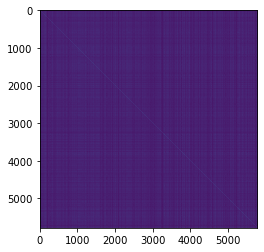

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if config["dataset_name"] == "bone marrow":
    adata = scv.datasets.bonemarrow()
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=config["sigma"], dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=config["num_neighbors"], flow_strength = config["flow_strength"])
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

In [ ]:
X.shape

torch.Size([5780, 30])

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = config["notebook"].replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[30, 20, 10, 5, 2],
            device=device,
            sigma=0.5,
            flow_strength=0.5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": config["diffdist_weight"],
            "kld": 0,
            "smoothness": config["smoothness_weight"],
            "flow neighbor loss": config["flow_neighbor_loss_weight"],
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

# Results

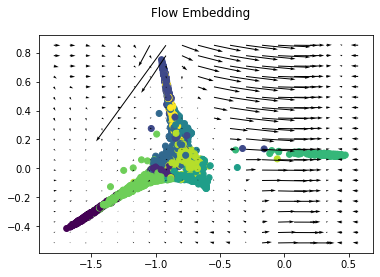

In [ ]:
FREDtrainer.visualize_embedding()

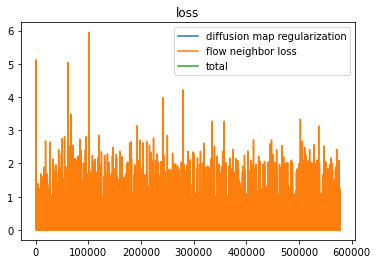

In [ ]:
FREDtrainer.visualize_loss()

# Qualitative analyses

In [ ]:
import sklearn 
silhouette = sklearn.metrics.silhouette_score(X, labels)

In [ ]:
print(f"## SCORES ## \n silhouette score: {silhouette} \n")

## SCORES ## 
 silhouette score: 0.15556398034095764 



# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'pprZRlVYPwztKvbQXSNX'

In [ ]:
import csv
spread_name = config["notebook"].replace('.ipynb','')
with open(f"{spread_name}.csv", 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([unid, config['sigma'], config['flow_strength'], config['flow_neighbor_loss_weight'],config['smoothness_weight'], config['diffdist_weight'], silhouette]) # unique id paired with silhouette score, so we can find the top performers easily